In [1]:
!pip3 install bert-extractive-summarizer
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import datasets
import numpy as np
import pandas as pd
from datasets import load_dataset, DatasetDict
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, AutoConfig
import torch
import torch.nn as nn
from transformers.optimization import Adafactor
import transformers
from summarizer import Summarizer

In [3]:
raw_datasets = load_dataset("xsum")
train_data = raw_datasets['train']
test_data = raw_datasets['test']

  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
summarizer = Summarizer()

def extract_important_sentence(example, model):
  text = example['document']
  result = model(text, num_sentences=1)
  return {'important_sentences':result}

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Load XSum Dataset

In [5]:
raw_datasets = DatasetDict(
    {
        "train": train_data.select(range(100)),
        "test": test_data.select(range(100)),
    }
)

# Extract Important Sentences

In [6]:
raw_datasets =  raw_datasets.map(lambda example:extract_important_sentence(example, summarizer))

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [7]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id', 'important_sentences'],
        num_rows: 100
    })
    test: Dataset({
        features: ['document', 'summary', 'id', 'important_sentences'],
        num_rows: 100
    })
})

# Load GPT2 Tokenizer

In [8]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token':'[PAD]'}) #Add pad token as gpt2 tokenizer doesn't have pad token on it

1

In [9]:
PAD_IDX = tokenizer.pad_token_id

In [10]:
PAD_IDX

50257

# Load GPT2 model

In [11]:
config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=512,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)
model = GPT2LMHeadModel(config).to("cuda")


# Pre-processing

In [12]:
# Set length of soft embedding prefix
prefix_len=100


In [13]:
def preprocess_function(examples, prefix_len=100, padding=True):
    text_column = 'document'
    summary_column = 'summary'
    important_column = 'important_sentences'

    max_source_length = 512  
    max_target_length = 512

    text = examples[text_column]
    targets = examples[summary_column]
    important = examples[important_column]

    inputs = " ".join(text.split(' '))[:200]  #for each sample we are only taking 200 words

    #tokenize inputs, label and important sentences
    model_inputs = tokenizer(inputs, return_tensors="pt", padding=padding, max_length=max_source_length, truncation=True)
    labels = tokenizer(targets, padding=padding, max_length=max_target_length, return_tensors="pt", truncation=True)
    importance_sentences = tokenizer(important, padding="max_length", max_length=prefix_len, return_tensors="pt", truncation=True)

    input_length = model_inputs['input_ids'].shape[1]
    target_length = labels["input_ids"].shape[1]

    #print(max_source_length,target_length,prefix_len,input_length)
    #concat input ids with importance sentences in the front and label in the back
    model_inputs['input_ids'] = torch.cat([importance_sentences['input_ids'], model_inputs['input_ids'],torch.full((1,max_source_length-target_length-prefix_len-input_length), PAD_IDX), labels['input_ids']],1)
    
    #concat label with -100 in the front and padding
    labels["input_ids"] = torch.cat([torch.full((1,prefix_len),-100), labels['input_ids'],torch.full((1,max_target_length-prefix_len-target_length), PAD_IDX)],1)
    model_inputs["labels"] = labels["input_ids"]

    #concat attention with 0 in the back
    attention_length = model_inputs["attention_mask"].shape[1]
    model_inputs["attention_mask"] = torch.cat([model_inputs["attention_mask"],torch.full((1,max_source_length-attention_length), 1)],1)

    return model_inputs

In [14]:
column_names = ['document', 'summary','id','important_sentences']
new_train_dataset = raw_datasets["train"].map(lambda example : preprocess_function(example,prefix_len),remove_columns=column_names)
new_test_dataset = raw_datasets["test"].map(lambda example : preprocess_function(example,prefix_len),remove_columns=column_names)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

# Prepare Data Loader

In [15]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [16]:
BATCH_SIZE = 8
new_train_dataset.set_format("torch")
loader = DataLoader(new_train_dataset, batch_size=BATCH_SIZE)

In [17]:
for batch in loader:
  break

In [18]:
print(batch)

{'input_ids': tensor([[[  464,  1336,  1575,  ...,  8865,  5278,    13]],

        [[   32,  2046, 10436,  ...,  1748,  7372,    13]],

        [[   37,  8056,  2743,  ..., 10018,  3900,    13]],

        ...,

        [[ 8890,   505, 34395,  ...,  7872,  4116,    13]],

        [[13414, 32752, 42100,  ...,   416,  1644,    13]],

        [[12193, 18299, 34632,  ..., 30711,   494,    13]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1]],

        ...,

        [[1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1]]]), 'labels': tensor([[[ -100,  -100,  -100,  ..., 50257, 50257, 50257]],

        [[ -100,  -100,  -100,  ..., 50257, 50257, 50257]],

        [[ -100,  -100,  -100,  ..., 50257, 50257, 50257]],

        ...,

        [[ -100,  -100,  -100,  ..., 50257, 50257, 50257]],

        [[ -100,  -100,  -100,  ..., 50257, 50257, 50257]],

        [[ -100,  -10

# Create Soft Embedding Model

In [19]:
class SoftEmbedding(nn.Module):
    def __init__(self, 
                wte: nn.Embedding,  #original transformer word token embedding
                n_tokens: int = 10, #number of tokens for each task
                random_range: float = 0.5, #range to init embedding
                initialize_from_vocab: bool = True):
        super(SoftEmbedding, self).__init__()
        self.wte = wte
        self.n_tokens = n_tokens
        self.learned_embedding = nn.parameter.Parameter(self.initialize_embedding(wte,
                                                                               n_tokens, 
                                                                               random_range, 
                                                                               initialize_from_vocab))
        # self.learned_embedding: (n_tokens, emb dim)
        # self.wte.weight:        (vocab size, emb dim)
        
    def initialize_embedding(self, 
                             wte: nn.Embedding,
                             n_tokens: int = 10, 
                             random_range: float = 0.5, 
                             initialize_from_vocab: bool = True):
        if initialize_from_vocab:
            return self.wte.weight[:n_tokens].clone().detach()
        return torch.FloatTensor(n_tokens, wte.weight.size(1)).uniform_(-random_range, random_range)
    
    #define the forward process
    def forward(self, tokens):
        #first get the embedding of the input text, which is the n_tokens:
        input_embedding = self.wte(tokens[:, self.n_tokens:])
        #input_embedding: b, input_len, emb dim
        
        #repeat the learned embedding to all batch size
        learned_embedding = self.learned_embedding.repeat(input_embedding.size(0), 1, 1)
        #input_embedding: b, n_tokens, emb dim
        
        concat_embed = torch.cat([learned_embedding, input_embedding], 1)
        #concat_embed: 1, input_len + n_tokens, emb dim
        
        return concat_embed

In [20]:
model_setup_for_prompt_tuning=False
if not model_setup_for_prompt_tuning:
  model.train()

  # Freeze model
  for param in model.parameters():
      param.requires_grad = False

  old_wte = model.get_input_embeddings()

  # Add softembedding module
  s_wte = SoftEmbedding(old_wte,
                        n_tokens=prefix_len,
                        initialize_from_vocab=True).to("cuda")
  model.set_input_embeddings(s_wte)

  # Set up optimizer
  params = [model.transformer.wte.learned_embedding]
  optimizer = Adafactor(params=params)

# Training Model

In [21]:
import pickle

iterations = 400
name = "prefix-8-512-imp_sentences-1-model"
losses = []
best_loss = float('inf')
for batch in loader:
  for i in range(iterations):
      optimizer.zero_grad()
      input=batch["input_ids"].to("cuda")
      attention = batch["attention_mask"].to("cuda")
      label = batch["labels"].cuda()
      output = model(input_ids=input,attention_mask = attention,labels=label)
      loss = output.loss
      losses.append(loss)
      loss.backward()
      optimizer.step()
      if i%10 == 0:
        print(f"{i}: Loss: {loss}")
  if loss < best_loss:
    best_loss = loss
    torch.save(model.transformer.wte.learned_embedding, f'{name}.pt')
    pickle.dump(model, open(f"{name}.pkl","wb"))

0: Loss: 10.431297302246094
10: Loss: 9.184200286865234
20: Loss: 8.146683692932129
30: Loss: 7.450375556945801
40: Loss: 6.940304279327393
50: Loss: 6.511963367462158
60: Loss: 6.188163757324219
70: Loss: 5.87896728515625
80: Loss: 5.599445819854736
90: Loss: 5.344512462615967
100: Loss: 5.10442590713501
110: Loss: 4.857799053192139
120: Loss: 4.582274913787842
130: Loss: 4.3274078369140625
140: Loss: 4.099809646606445
150: Loss: 3.9089207649230957
160: Loss: 3.720642328262329
170: Loss: 3.5714871883392334
180: Loss: 3.412111759185791
190: Loss: 3.290515422821045
200: Loss: 3.1735172271728516
210: Loss: 3.074399709701538
220: Loss: 2.9912972450256348
230: Loss: 2.908116102218628
240: Loss: 2.8312923908233643
250: Loss: 2.7531321048736572
260: Loss: 2.7036173343658447
270: Loss: 2.649981737136841
280: Loss: 2.6146130561828613
290: Loss: 2.578566789627075
300: Loss: 2.5518712997436523
310: Loss: 2.523475408554077
320: Loss: 2.4941956996917725
330: Loss: 2.471369504928589
340: Loss: 2.45

# Plot Training Loss

In [31]:
final_losses = [loss.item() for loss in losses]

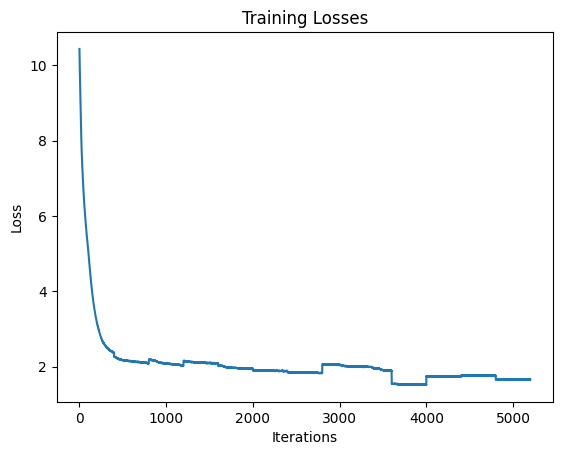

In [32]:
import matplotlib.pyplot as plt
final_losses = [loss.item() for loss in losses]
# Create a figure and axis object
fig, ax = plt.subplots()

# Create the line plot
ax.plot(final_losses)

# Add a title and axis labels
ax.set_title('Training Losses')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')

# Display the plot
plt.show()

# Testing Model

In [33]:
new_test_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})

In [34]:
new_test_dataset.set_format("pytorch")

In [35]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
def top_k_logits(logits, k,topk=0.7):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

In [36]:
def generate(examples, temperature, output_length = 120):
  model.eval();
  with torch.no_grad():
    tokens = []
    input_ids = examples['input_ids'].cuda()
    #attention_mask = torch.tensor(examples['attention_mask']).cuda()
    summary_ids = input_ids.clone()

    #summary_attention = attention_mask.clone()
    for k in range(output_length):
      logits = model(input_ids=input_ids).logits
      logits = logits[:, -1, :] / temperature
      logits = top_k_logits(logits, 10)
      probs = F.softmax(logits, dim=-1)   
      next_token = torch.multinomial(probs, num_samples=1)
      while next_token == tokenizer.pad_token_id:
          next_token = torch.multinomial(probs, num_samples=1)
      summary_ids = torch.cat([summary_ids, next_token], dim=1)
      input_ids = summary_ids
      #summary_attention = 
      #attention_mask = torch.cat([attention_mask,torch.full((1,1), 1).cuda()],1).cuda()
    #print(summary_ids)
    summary = tokenizer.decode(summary_ids.squeeze(), skip_special_tokens=True)
    return {'output_example':summary}

In [39]:
res = generate(new_test_dataset[0],0.7,120)

In [40]:
res['output_example'] #output = important_sentences + input_document + summary + generated summary 

'Prison Link Cymru had 1,099 referrals in 2015-16 and said some ex-offenders were living rough for up to a year before finding suitable accommodation.Prison Link Cymru had 1,099 referrals in 2015-16 and said some ex-offenders were living rough for up to a year before finding suitable accommodation.\nWorkers at the charity claim investment in housingThere is a "chronic" need for more housing for prison leavers in Wales, according to a charity. rag rag Wasserman Browse dwindlinglegates Browse prohibits servicing Cheap Cheap Cheap Adds Diversity scouting SaladletonletonWHEREasuresasureslegates Mour Cheapacles minimized iter dwindling babys podium indefinitely backdrop Browse adopting dwindling friendshipslialia Cheap dwindling indefinitely indefinitely Rage®legates Advancelegates tamp dwindling babys Per Per Per Maher babys babysICK Doudonalddonald minimizedleton Reprodu fortun dwindlingzoszoszos rehab babys Dough monthTP Trooper rehab rehab dwindling dwindling dwindlingDN Norton Browsele

In [ ]:
res['output_example']

In [ ]:
temperatures = [0.5,0.7,0.8,1.0]
results = []
for temperature in temperatures:
  results.append(new_test_dataset.map(lambda example:generate(example,temperature,120)))

In [ ]:
results[0]['test']['output_example'][0]